In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import torch.nn.functional as F
import gc
import numpy as np
from IPython.display import clear_output
from transformers import T5ForConditionalGeneration, AutoTokenizer, Adafactor

device = torch.device('cuda')

In [2]:
from ModelTrain import *
from metrics import *
from dataset_generator import *

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=1024)

### Fine-tune T5-base for length <= 30

In [4]:
train_dataset = TrainDataset(tokenizer, num_obj=100000, min_len=1,
                            max_len=30, eos=tokenizer.eos_token, prompts=True)

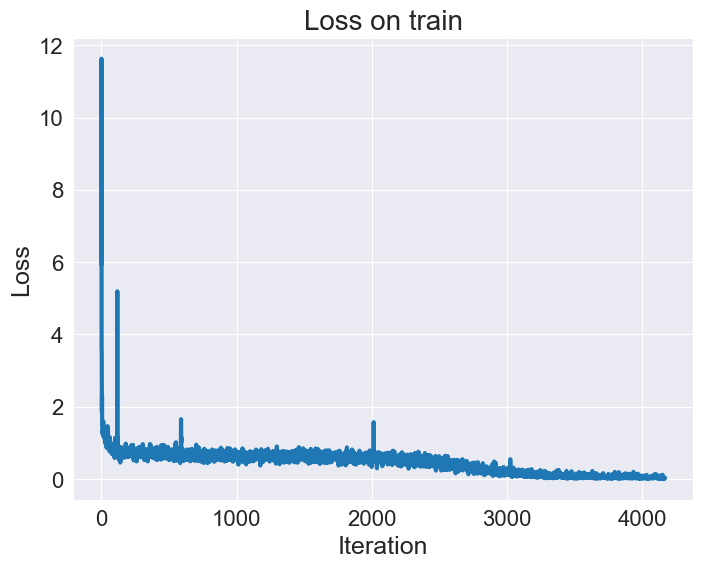

In [5]:
num_epochs = 1
batch_size = 24

try:
    del net
except:
    pass
try:
    del model
except:
    pass
gc.collect()
torch.cuda.empty_cache()

net = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
model = Model(net, tokenizer)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = Adafactor(model.net.parameters())

model.train(train_loader,
           optimizer, num_epochs,
           scheduler=None,
           store_path="t5-base_30_with_prompts.pt")

### Fine-tune for <=100

In [4]:
train_dataset100 = TrainDataset(tokenizer, num_obj=100000, min_len=1,
                            max_len=100, eos=tokenizer.eos_token, prompts=True)

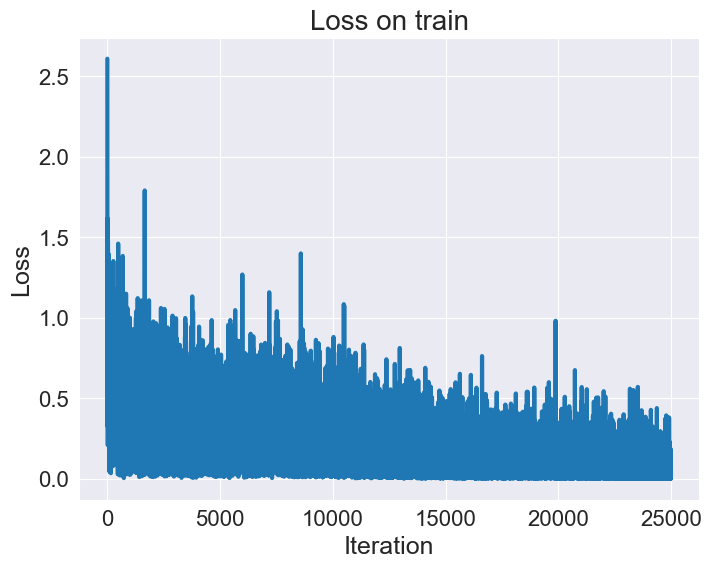

In [5]:
num_epochs = 1
batch_size = 4

try:
    del net
except:
    pass
try:
    del model
except:
    pass
gc.collect()
torch.cuda.empty_cache()

net = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
model = Model(net, tokenizer)


train_loader100 = DataLoader(train_dataset100, batch_size=batch_size, shuffle=True)

optimizer = Adafactor(model.net.parameters())

model.train(train_loader100,
           optimizer, num_epochs,
           scheduler=None,
           store_path="t5-base_100_with_prompts.pt",
           init_weights_path="t5-base_30_with_prompts.pt")

### Remove text prompts, let input be "a + b = "

In [4]:
train_dataset30_noprompts = TrainDataset(tokenizer, num_obj=50000, min_len=1,
                            max_len=30, eos=tokenizer.eos_token, prompts=False)

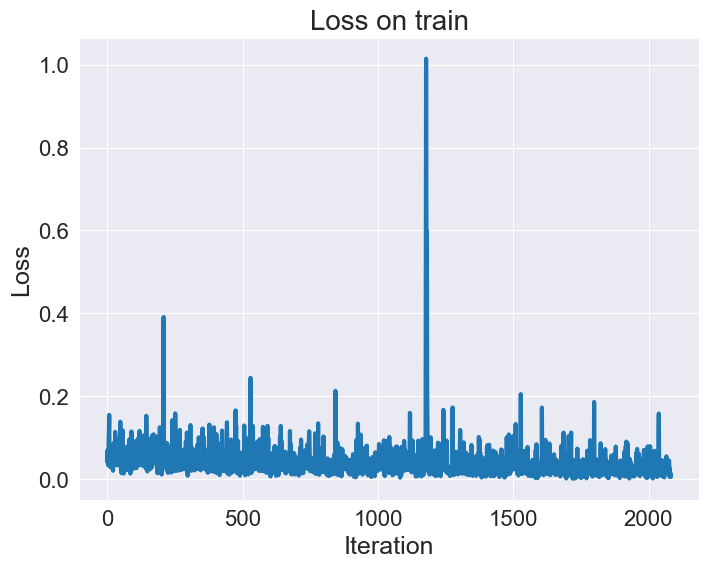

In [5]:
num_epochs = 1
batch_size = 24

try:
    del model
except:
    pass
model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

gc.collect()
torch.cuda.empty_cache()

train_loader30_noprompts = DataLoader(train_dataset30_noprompts, 
                                    batch_size=batch_size, shuffle=True)

optimizer = Adafactor(model.parameters())

train_model(model, train_loader30_noprompts,
           optimizer, num_epochs,
           scheduler=None,
           store_path="t5-base_30_without_prompts.pt",
           init_weights_path="t5-base_30_with_prompts.pt")

### The same for longer numbers

In [4]:
train_dataset100_noprompts = TrainDataset(tokenizer, num_obj=100000, min_len=1,
                            max_len=100, eos=tokenizer.eos_token, prompts=False)

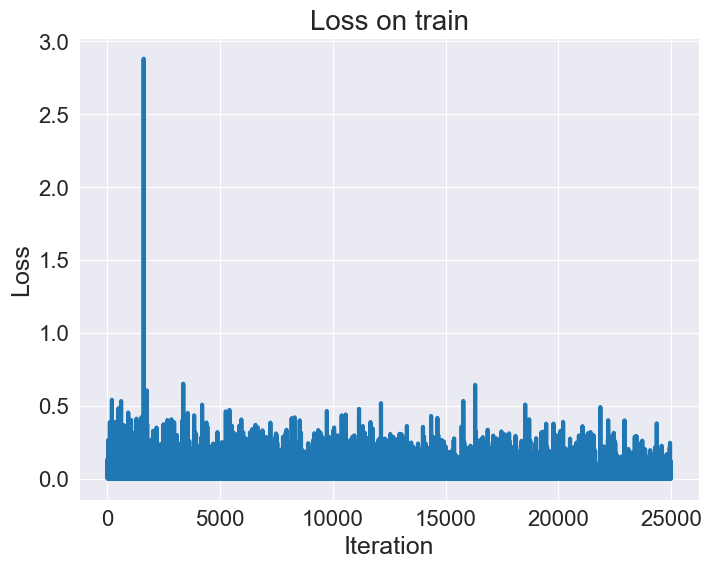

In [6]:
num_epochs = 1
batch_size = 6

try:
    del net
except:
    pass
try:
    del model
except:
    pass
gc.collect()
torch.cuda.empty_cache()

net = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
model = Model(net, tokenizer)

train_loader100_noprompts = DataLoader(train_dataset100_noprompts, 
                                    batch_size=batch_size, shuffle=True)

optimizer = Adafactor(model.network.parameters())

model.train(train_loader100_noprompts,
           optimizer, num_epochs,
           scheduler=None,
           store_path="t5-base_100_without_prompts.pt",
           init_weights_path="t5-base_100_with_prompts.pt")

In [6]:
model_path = "t5-base_30_without_prompts.pt"

try:
    del model
except:
    pass
try:
    del net
except:
    pass

net = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
net.load_state_dict(torch.load(model_path))

model = Model(net, tokenizer)

test_datasets30 = []
row_labels30 = []
metrics = [acc, mean_digit_acc]
col_labels = ['accuracy', 'per_digit_accuracy']

test_datasets30.append(TestDataset(num_obj=1000, min_len=1, max_len=5))
row_labels30.append('len = 1-5')
test_datasets30.append(TestDataset(num_obj=1000, min_len=6, max_len=15))
row_labels30.append('len = 6-15')
test_datasets30.append(TestDataset(num_obj=1000, min_len=16, max_len=30))
row_labels30.append('len = 16-30')
test_datasets30.append(TestDataset(num_obj=3000, min_len=1, max_len=30))
row_labels30.append('len = 1-30')

metrics_30_noprompts = evaluate(model, test_datasets30,
                               metrics, row_labels30, col_labels)

In [7]:
metrics_30_noprompts

,accuracy,per_digit_accuracy
len = 1-5,0.978000,0.992517
len = 6-15,0.961000,0.995173
len = 16-30,0.871000,0.981427
len = 1-30,0.932667,0.993148


In [10]:
metrics_30_noprompts.to_csv('metrics_30_noprompts.csv')

In [8]:
model_path = "t5-base_100_without_prompts.pt"

try:
    del model
except:
    pass
try:
    del net
except:
    pass

net = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
net.load_state_dict(torch.load(model_path))

model = Model(net, tokenizer)

test_datasets100 = []
row_labels100 = []
metrics = [acc, mean_digit_acc]
col_labels = ['accuracy', 'per_digit_accuracy']

test_datasets100.append(TestDataset(num_obj=1000, min_len=1, max_len=15))
row_labels100.append('len = 1-15')
test_datasets100.append(TestDataset(num_obj=1000, min_len=16, max_len=30))
row_labels100.append('len = 16-30')
test_datasets100.append(TestDataset(num_obj=1000, min_len=31, max_len=60))
row_labels100.append('len = 31-60')
test_datasets100.append(TestDataset(num_obj=1000, min_len=61, max_len=100))
row_labels100.append('len = 61-100')
test_datasets100.append(TestDataset(num_obj=4000, min_len=1, max_len=100))
row_labels100.append('len = 1-100')

metrics_100_noprompts = evaluate(model, test_datasets100,
                               metrics, row_labels100,
                               col_labels)

In [9]:
metrics_100_noprompts

,accuracy,per_digit_accuracy
len = 1-15,0.992,0.997810
len = 16-30,0.991,0.997830
len = 31-60,0.969,0.996110
len = 61-100,0.699,0.924891
len = 1-100,0.930,0.984668


In [11]:
metrics_100_noprompts.to_csv('metrics_100_noprompts.csv')

## Another option is LoRA for a bigger model

In [5]:
from peft import get_peft_config, get_peft_model, LoraModel, LoraConfig
from transformers import AutoModelForSeq2SeqLM

model_name_or_path = "t5-large"
tokenizerL = AutoTokenizer.from_pretrained(model_name_or_path, model_max_length=1024)

lora_config = LoraConfig(
    peft_type="LORA",
    task_type="SEQ_2_SEQ_LM",
    r=32,
    lora_alpha=64,
    target_modules=["q", "v"],
    lora_dropout=0.01
)

In [7]:
netL = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
netL = get_peft_model(netL, lora_config)
netL.print_trainable_parameters()

trainable params: 9437184 || all params: 747105280 || trainable%: 1.2631665513058614


In [8]:
train_datasetL30 = TrainDataset(tokenizerL, num_obj=50000, min_len=1,
                        max_len=30, eos=tokenizerL.eos_token, prompts=False)

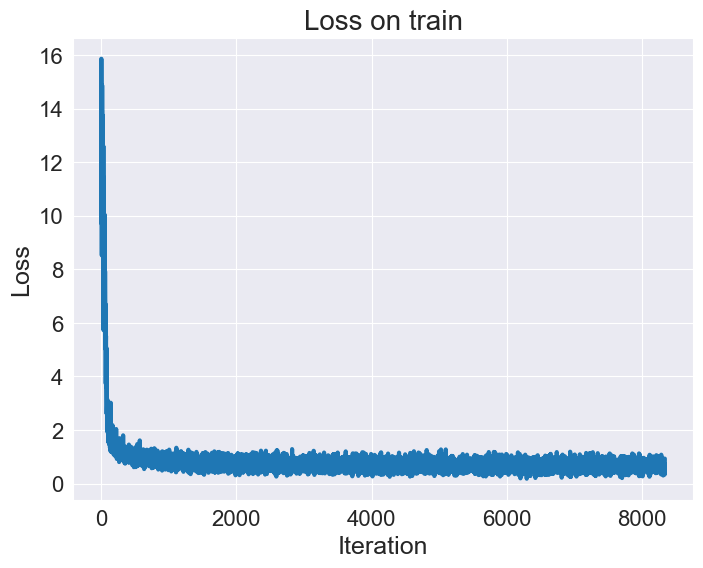

In [8]:
num_epochs = 1
batch_size = 6

try:
    del netL
except:
    pass
try:
    del modelL
except:
    pass
gc.collect()
torch.cuda.empty_cache()

netL = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
netL = get_peft_model(netL, lora_config)

modelL = Model(netL, tokenizerL).to(device)

train_loaderL30 = DataLoader(train_datasetL30, batch_size=batch_size, 
                             shuffle=True)

optimizer = Adafactor(modelL.network.parameters())

modelL.train(train_loaderL30,
           optimizer, num_epochs,
           scheduler=None,
           store_path="LoRA_30.pt",
           init_weights_path=None,
           device='cuda')

In [6]:
model_path = "LoRA_30.pt"

try:
    del modelL
except:
    pass
try:
    del netL
except:
    pass

netL = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
netL = get_peft_model(netL, lora_config)
netL.load_state_dict(torch.load(model_path))

modelL = Model(netL, tokenizerL).to(device)
modelL.network = modelL.network.merge_and_unload()

test_datasetsL30 = []
row_labelsL30 = []
metrics = [acc, mean_digit_acc]
col_labels = ['accuracy', 'per_digit_accuracy']

test_datasetsL30.append(TestDataset(num_obj=1000, min_len=1, max_len=5))
row_labelsL30.append('len = 1-5')
test_datasetsL30.append(TestDataset(num_obj=1000, min_len=6, max_len=15))
row_labelsL30.append('len = 6-15')
test_datasetsL30.append(TestDataset(num_obj=1000, min_len=16, max_len=30))
row_labelsL30.append('len = 16-30')
test_datasetsL30.append(TestDataset(num_obj=3000, min_len=1, max_len=30))
row_labelsL30.append('len = 1-30')

metrics_LoRA30 = evaluate(modelL, test_datasetsL30,
                               metrics, row_labelsL30,
                               col_labels)

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/3000 [00:00<?, ?it/s]

In [9]:
metrics_LoRA30

,accuracy,per_digit_accuracy
len = 1-5,0.072,0.407517
len = 6-15,0.000,0.297325
len = 16-30,0.000,0.237174
len = 1-30,0.011,0.502112


In [10]:
metrics_LoRA30.to_csv("metrics_LoRA30.csv")

## The final option -- RNN

In [162]:
from itertools import combinations_with_replacement as comb
from itertools import product as prod


class InpTokenizer():
    def __init__(self):
        self.eos = '</s>'
        #self.idx_to_token =  ['</s>'] + [set(elem) for elem in list(comb([str(elem) for elem in range(0,10)], 2))]
        self.idx_to_token = ['</s>'] + list(prod(list(range(0,10)), repeat=2))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        
        
    def encode(self, a, b):
        a, b = list(str(a))[::-1], list(str(b))[::-1]
        max_len = max(len(a), len(b))
        a, b = a + ['0'] * (max_len - len(a)), b + ['0'] * (max_len - len(b))
        
        out = [self.token_to_idx[(int(a[i]), int(b[i]))] for i in range(max_len)] + [self.token_to_idx[self.eos]]
        return out
    
    
class OutTokenizer():
    def __init__(self):
        self.eos = '</s>'
        self.pad = '<PAD>'
        self.idx_to_token = ['</s>'] + ['<PAD>'] + [str(elem) for elem in list(range(10))]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        self.eos_idx = self.token_to_idx[self.eos]
        
    def encode(self, a):
        a = list(str(a))[::-1]    
        out = [self.token_to_idx[elem] for elem in a] + [self.token_to_idx[self.eos]]
        return out
    
    def decode(self, a):
        a = a[::-1]
        out = [self.idx_to_token[idx] for idx in a if idx != self.eos_idx]
        return ''.join(out)

In [153]:
class RNN_model(nn.Module):
    def __init__(self, inp_tokenizer,
                 out_tokenizer,
                 inp_vocab_size=101,
                 out_vocab_size=12,
                 hidden_size=32,
                 num_layers=2,
                 dropout=0,
                 emb_size=64):
        super().__init__()
        
        self.inp_vocab_size = inp_vocab_size
        self.out_vocab_size = out_vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.hidden_size = hidden_size
        self.inp_tokenizer = inp_tokenizer
        self.out_tokenizer = out_tokenizer
        
        self.emb = nn.Embedding(inp_vocab_size, emb_size)
        
        self.rnn = nn.RNN(input_size=emb_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout)
        
        self.out = nn.Linear(hidden_size, out_vocab_size)
    
    def forward(self, x, y):
        logps = []
        
        seq = []
        out, h_n = self.rnn(self.emb(x[0]).view(1,-1))
        next_logp = F.log_softmax(self.out(out), dim=-1)        
        seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
        logps.append(next_logp)
        
        i = 1
        while (i < len(y)):
            if (len(x) == len(y)) or (i < len(x)):
                out, h_n = self.rnn(self.emb(x[i]).view(1,-1), h_n)
            else:
                out, h_n = self.rnn(self.emb(torch.tensor(self.out_tokenizer.token_to_idx["<PAD>"])).view(1,-1), h_n)
            next_logp = F.log_softmax(self.out(out), dim=-1)        
            seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
            logps.append(next_logp)
            i += 1
        
        return torch.cat(logps)
    
    def generate(self, a, b):
        inp_str = torch.tensor(inp_tokenizer.encode(a, b))
        inp_len = len(inp_str)
        
        seq = []
        out, h_n = self.rnn(self.emb(inp_str[0]).view(1,-1))
        next_logp = F.log_softmax(self.out(out), dim=-1)        
        seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
        i = 1
        while (len(seq) < inp_len) and (seq[-1] != self.out_tokenizer.eos_idx):
        
            out, h_n = self.rnn(self.emb(inp_str[i]).view(1,-1), h_n)
            next_logp = F.log_softmax(self.out(out), dim=-1)        
            seq.append(torch.argmax(next_logp, dim=-1).detach().cpu())
            i += 1
        
        return self.out_tokenizer.decode(seq)

In [140]:
def train_rnn(model, dataset, optimizer):
    model.train()
    loss_by_iter = []
    
    for i_step, ((a,b), ans) in tqdm(enumerate(dataset),  desc='Iteration',
                                                 colour="#00ff00"):
        model.zero_grad()
        
        x = torch.tensor(model.inp_tokenizer.encode(a, b))
        y = torch.tensor(model.out_tokenizer.encode(ans))
        
        logp = model(x, y)
        
        loss = F.nll_loss(logp.contiguous().view(-1, model.out_vocab_size), 
                          y.view(-1), 
                          ignore_index=model.out_tokenizer.token_to_idx['<PAD>'])
        loss.backward()
        loss_by_iter.append(loss.detach())
        optimizer.step()

        if (i_step + 1) % 100 == 0:
            clear_output(True)
            plot_progress(loss_by_iter)
            plt.show()
        
        
        
def plot_progress(loss, ax=None, title="Loss on train"):
    if ax is None:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

    ax.plot(np.arange(len(loss)), loss, lw=3,
            color=sns.color_palette()[0], )

    ax.set_xlabel("Iteration", fontsize=18)
    ax.set_ylabel('Loss', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)

    ax.set_title(title, fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [165]:
rnn_dataset = TestDataset(num_obj=100000, min_len=1, max_len=200)
inp_tokenizer = InpTokenizer()
out_tokenizer = OutTokenizer()

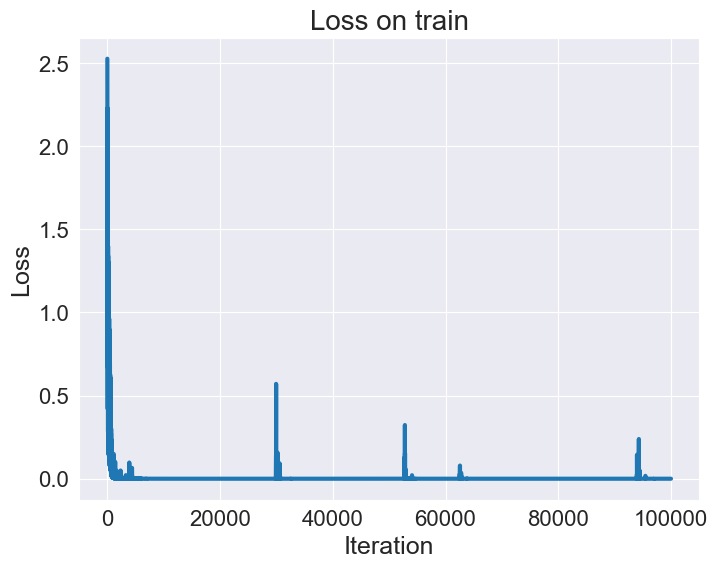

In [145]:
rnn_model = RNN_model(inp_tokenizer=inp_tokenizer,
                 out_tokenizer=out_tokenizer,
                 inp_vocab_size=101,
                 out_vocab_size=12,
                 hidden_size=64,
                 num_layers=2,
                 dropout=0,
                 emb_size=64)

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

train_rnn(rnn_model, rnn_dataset, rnn_optimizer)

In [146]:
torch.save(rnn_model.state_dict(), "rnn_model.pt")

In [156]:
def evaluate_rnn(model, datasets, metrics, row_labels, col_labels):
    model.eval()
    t = pd.DataFrame(data=np.zeros([len(datasets), len(metrics)]),
                     index=row_labels,
                     columns=col_labels)

    for row in tqdm(range(len(datasets)), desc='Datasets', colour="#005500"):
        prediction = []
        target = []
        for (a, b), trg in tqdm(datasets[row], desc='Elements', colour="#00ff00"):
            prediction.append(model.generate(a, b))
            target.append(trg)
            for col in range(len(metrics)):
                metric = metrics[col](prediction, target)
                t.iloc[row][col] = metric
    return t

In [172]:
model_path = "rnn_model.pt"

try:
    del rnn_model
except:
    pass


rnn_model = RNN_model(inp_tokenizer=inp_tokenizer,
                 out_tokenizer=out_tokenizer,
                 inp_vocab_size=101,
                 out_vocab_size=12,
                 hidden_size=64,
                 num_layers=2,
                 dropout=0,
                 emb_size=64)

rnn_model.load_state_dict(torch.load(model_path))

test_datasetsRNN = []
row_labelsRNN = []
metrics = [acc, mean_digit_acc]
col_labels = ['accuracy', 'per_digit_accuracy']

test_datasetsRNN.append(TestDataset(num_obj=1000, min_len=1, max_len=20))
row_labelsRNN.append('len = 1-20')
test_datasetsRNN.append(TestDataset(num_obj=1000, min_len=21, max_len=50))
row_labelsRNN.append('len = 21-50')
test_datasetsRNN.append(TestDataset(num_obj=1000, min_len=51, max_len=100))
row_labelsRNN.append('len = 51-100')
test_datasetsRNN.append(TestDataset(num_obj=1000, min_len=101, max_len=200))
row_labelsRNN.append('len = 101-200')
test_datasetsRNN.append(TestDataset(num_obj=1000, min_len=201, max_len=1000))
row_labelsRNN.append('len = 201-1000')
test_datasetsRNN.append(TestDataset(num_obj=5000, min_len=1, max_len=1000))
row_labelsRNN.append('len = 1-1000')

metrics_rnn = evaluate_rnn(rnn_model, test_datasetsRNN,
                               metrics, row_labelsRNN,
                               col_labels)

Datasets:   0%|          | 0/6 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/1000 [00:00<?, ?it/s]

Elements:   0%|          | 0/5000 [00:00<?, ?it/s]

In [173]:
metrics_rnn

,accuracy,per_digit_accuracy
len = 1-20,1.0,1.0
len = 21-50,1.0,1.0
len = 51-100,1.0,1.0
len = 101-200,1.0,1.0
len = 201-1000,1.0,1.0
len = 1-1000,1.0,1.0


In [174]:
metrics_rnn.to_csv("metrics_rnn.csv")